## Preliminaries
1. Install and import required packages

In [1]:
!pip install torch

In [2]:
import os
os.environ['PHIFLOW_BACKEND'] = 'torch'  # before importing PhiFlow

from phi.flow import *

2. Set up architecture for PINN

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MHWNetwork(nn.Module):
    '''
    Defines a NN for solving the Modified (2D) Hasegawa-Wakatani (MHW) system of equations.
    Hidden layers = 8 fully connected layers, tanh activations, 20 units each.
    Output layers: phi, zeta, n - each returning a single value per point
    Input: tensor of shape (batch_size, 3) corresponding to (x, y, t).
    '''
    def __init__(self, num_hidden_layers=8, num_neurons=20):
        super(MHWNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList([
            nn.Linear(3 if i == 0 else num_neurons, num_neurons) for i in range(num_hidden_layers)
        ])
        self.phi_output = nn.Linear(num_neurons, 1)
        self.zeta_output = nn.Linear(num_neurons, 1)
        self.n_output = nn.Linear(num_neurons, 1)

    def forward(self, inputs):
        """
        Forward pass for batch inputs: expects shape (batch_size, 3), where 3 corresponds to (x, y, t)
        """
        x = inputs
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        phi_output = self.phi_output(x)
        zeta_output = self.zeta_output(x)
        n_output = self.n_output(x)
        return phi_output, zeta_output, n_output

# Instantiate model
model = MHWNetwork(num_hidden_layers=8, num_neurons=20)

3. Define necessary functions for the MHW system and PINN - grid setup, loss, training

In [4]:
import numpy as np
import torch

def calculate_grid_spacing(Nx, Ny):
    x_spacing = 2.0 / (Nx - 1)
    y_spacing = 2.0 / (Ny - 1)
    return x_spacing, y_spacing

def create_grid(Nx=128, Ny=128, T=33, batch_size=30):
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    t = np.linspace(0, 1, T)
    grids_xy_t = np.meshgrid(x, y, t, indexing='ij')
    grid_x, grid_y, grid_t = [torch.tensor(g, dtype=torch.float32) for g in grids_xy_t]

    inputs = torch.stack([grid_x, grid_y, grid_t], dim=-1)  # (Nx, Ny, T, 3)
    inputs = inputs.unsqueeze(0).repeat(batch_size, 1, 1, 1, 1)  # (batch, Nx, Ny, T, 3)

    dx, dy = calculate_grid_spacing(Nx, Ny)
    return inputs, grid_x, grid_y, grid_t, dx, dy

def calculate_gradients(field, axis, epsilon):
    shifted_forward = torch.roll(field, shifts=-1, dims=axis)
    shifted_backward = torch.roll(field, shifts=1, dims=axis)
    shifted_forward_2 = torch.roll(field, shifts=-2, dims=axis)
    shifted_backward_2 = torch.roll(field, shifts=2, dims=axis)
    return (-shifted_forward_2 + 8 * shifted_forward - 8 * shifted_backward + shifted_backward_2) / (12 * epsilon)

def poisson_bracket(f, g, dx, dy):
    f_x = calculate_gradients(f, axis=1, epsilon=dx)
    f_y = calculate_gradients(f, axis=2, epsilon=dy)
    g_x = calculate_gradients(g, axis=1, epsilon=dx)
    g_y = calculate_gradients(g, axis=2, epsilon=dy)
    return f_x * g_y - f_y * g_x

def poisson_solver_fft(zeta, Nx, Ny):
    batch_size = zeta.shape[0]
    kx = torch.fft.fftshift(torch.arange(-Nx // 2, Nx // 2, dtype=torch.float32)) * (np.pi / (Nx // 2))
    ky = torch.fft.fftshift(torch.arange(-Ny // 2, Ny // 2, dtype=torch.float32)) * (np.pi / (Ny // 2))
    KX, KY = torch.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2
    K2 = K2.unsqueeze(0).repeat(batch_size, 1, 1)  # (batch, Nx, Ny)
    zeta_hat = torch.fft.fft2(zeta)
    K2 = torch.where(K2 == 0, torch.tensor(1e-10), K2)
    phi_hat = zeta_hat / (-K2)
    return torch.fft.ifft2(phi_hat).real

def grad4(field, dx, dy):
    field_x = calculate_gradients(field, axis=1, epsilon=dx)
    field_y = calculate_gradients(field, axis=2, epsilon=dy)
    field_xx = calculate_gradients(field_x, axis=1, epsilon=dx)
    field_yy = calculate_gradients(field_y, axis=2, epsilon=dy)
    return field_xx + field_yy

def zonal_average(field, axis=1):
    return torch.mean(field, dim=axis, keepdim=True)

def non_zonal_component(field, axis=1):
    return field - zonal_average(field, axis=axis)

def boundary_tx(Nx, Ny, batch_size):
    x = torch.linspace(-1.0, 1.0, Nx)
    y = torch.linspace(-1.0, 1.0, Ny)
    x_grid, y_grid = torch.meshgrid(x, y, indexing='ij')
    x_grid = x_grid.unsqueeze(0).repeat(batch_size, 1, 1)
    y_grid = y_grid.unsqueeze(0).repeat(batch_size, 1, 1)
    zeta = torch.randn(batch_size, Nx, Ny) * 0.01
    n = torch.randn(batch_size, Nx, Ny) * 0.01
    t = torch.zeros((batch_size, Nx, Ny), dtype=torch.float32)
    phi = poisson_solver_fft(zeta, Nx, Ny)
    return x_grid, y_grid, t, zeta, n, phi

def open_boundary(Nx, Ny, batch_size):
    x = torch.linspace(-1.0, 1.0, Nx)
    y = torch.linspace(-1.0, 1.0, Ny)
    x_boundary, y_boundary = torch.meshgrid(x, y, indexing='ij')
    x_boundary = x_boundary.unsqueeze(0).repeat(batch_size, 1, 1)
    y_boundary = y_boundary.unsqueeze(0).repeat(batch_size, 1, 1)
    zeta_boundary = torch.randn(batch_size, Nx, Ny) * 0.1
    n_boundary = torch.randn(batch_size, Nx, Ny) * 0.1
    t_boundary = torch.zeros((batch_size, Nx, Ny), dtype=torch.float32)
    dx, dy = calculate_grid_spacing(Nx, Ny)
    phi_boundary = poisson_bracket(zeta_boundary, n_boundary, dx, dy)
    return x_boundary, y_boundary, t_boundary, zeta_boundary, n_boundary, phi_boundary

4. Introduce MHW system (i.e., physics loss)

In [5]:
import torch

def MHW_physics_loss(phi, zeta, n, x, y, t, Nx, Ny, alpha=0.5, kappa=1.0, mu=1.0, epsilon=0.0157):
    """
    Physics-based loss function for the MHW System in 2D with non-zonal components.

    Parameters:
        phi, zeta, n: Tensor fields of shape (batch_size, Nx, Ny)
        x, y, t: Spatial and temporal coordinates
        Nx, Ny: Grid dimensions
        alpha, kappa, mu: Physical parameters
        epsilon: Small value for numerical stability

    Returns:
        loss_zeta, loss_n: Scalar loss values computed from residuals
    """

    # Compute grid spacing
    dx, dy = calculate_grid_spacing(Nx, Ny)

    # Compute non-zonal components
    tilde_phi = non_zonal_component(phi, axis=1)  # (batch_size, Nx, Ny)
    tilde_n = non_zonal_component(n, axis=1)  # (batch_size, Nx, Ny)

    # Poisson brackets using non-zonal components
    zeta_PB = poisson_bracket(tilde_phi, zeta, dx, dy)  # (batch_size, Nx, Ny)
    n_PB = poisson_bracket(tilde_phi, tilde_n, dx, dy)  # (batch_size, Nx, Ny)

    # Fourth-order Laplacians (batch-wise computation)
    grad4_zeta = grad4(zeta, dx, dy)  # (batch_size, Nx, Ny)
    grad4_n = grad4(tilde_n, dx, dy)  # (batch_size, Nx, Ny)

    # Compute ∂tilde{φ}/∂y term (gradient along y-axis)
    grad_tilde_phi_y = calculate_gradients(tilde_phi, axis=2, epsilon=dy)  # PyTorch y-axis = axis 2

    # Compute residuals for the MHW equations
    loss_zeta_unnorm = zeta_PB - alpha * (tilde_phi - tilde_n) + mu * grad4_zeta
    loss_n_unnorm = n_PB - alpha * (tilde_phi - tilde_n) + kappa * grad_tilde_phi_y + mu * grad4_n

    # Compute L2 norm of residuals over the entire batch
    loss_zeta = torch.sqrt(torch.mean(loss_zeta_unnorm ** 2))
    loss_n = torch.sqrt(torch.mean(loss_n_unnorm ** 2))

    return loss_zeta, loss_n

5. Define grids for each input (phi, n, zeta for the MHW system)

In [6]:
import torch

# Define grid dimensions
Nx = 128  # Number of grid points in the x-direction
Ny = 128  # Number of grid points in the y-direction
T = 33    # Number of time steps
batch_size = 30  # Fixed batch size

def calculate_grid_spacing(Nx, Ny):
    """
    Calculate uniform grid spacing for a domain spanning [-1, 1] in x and y directions.
    """
    x_spacing = 2.0 / (Nx - 1)
    y_spacing = 2.0 / (Ny - 1)
    return x_spacing, y_spacing

def create_grid(Nx=128, Ny=128, T=33, batch_size=30):
    """
    Creates a 3D space-time grid and prepares it for batch processing.
    """
    # Create meshgrid for x, y, t
    x = torch.linspace(-1, 1, Nx)
    y = torch.linspace(-1, 1, Ny)
    t = torch.linspace(0, 1, T)

    grid_x, grid_y, grid_t = torch.meshgrid(x, y, t, indexing='ij')

    # Stack to form (Nx, Ny, T) grid
    inputs = torch.stack([grid_x, grid_y, grid_t], dim=-1)  # Shape: (Nx, Ny, T, 3)

    # Add batch dimension and tile it
    inputs = inputs.unsqueeze(0)  # Shape: (1, Nx, Ny, T, 3)
    inputs = inputs.repeat(batch_size, 1, 1, 1, 1)  # Shape: (batch_size, Nx, Ny, T, 3)

    dx, dy = calculate_grid_spacing(Nx, Ny)
    return inputs, grid_x, grid_y, grid_t, dx, dy

# Create the grid
inputs, grid_x, grid_y, grid_t, dx, dy = create_grid(Nx=Nx, Ny=Ny, T=T, batch_size=batch_size)

# Initialize the model
model = MHWNetwork(num_hidden_layers=8, num_neurons=20)

# Forward pass through the model (batch processing)
phi_output, zeta_output, n_output = model(inputs)  # Outputs: (batch_size, Nx, Ny, T)

# Ensure outputs match expected shape
phi_grid = phi_output  # Shape: (batch_size, Nx, Ny, T)
zeta_grid = zeta_output  # Shape: (batch_size, Nx, Ny, T)
n_grid = n_output  # Shape: (batch_size, Nx, Ny, T)

# Compute non-zonal components before passing to loss function
tilde_phi = non_zonal_component(phi_grid, axis=1)  # Filtering along x-axis (default behavior)
tilde_n = non_zonal_component(n_grid, axis=1)  # Filtering along x-axis (default behavior)

6. Pre-training visualization of each grid (phi, n, zeta)

Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)
Debug: Shape of input array a: (30, 128, 128, 33)


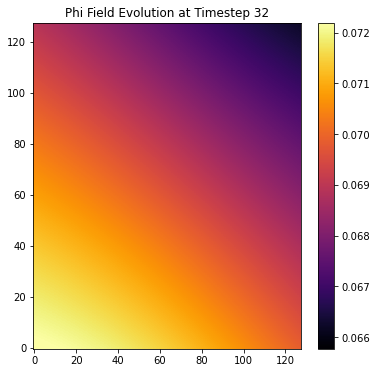

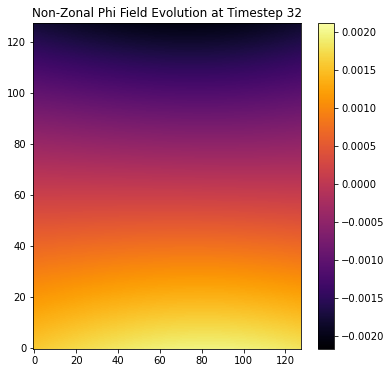

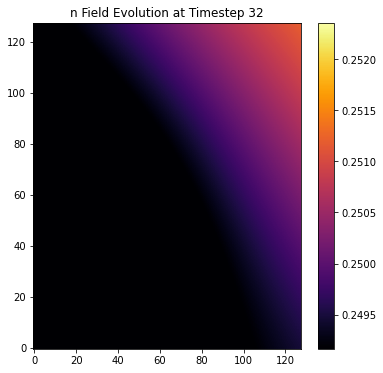

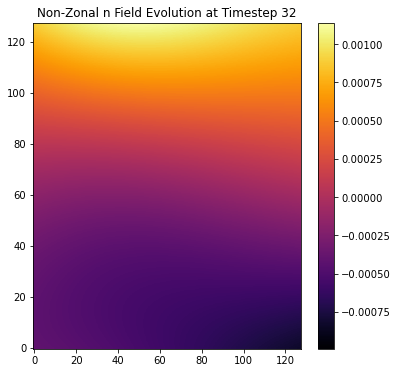

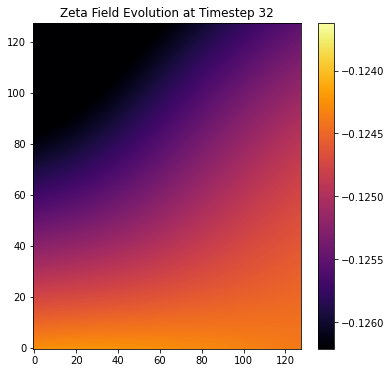

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display

def animate_field(a, title, batch_index=0):
    """
    Create an animation for the time evolution of a field.

    Parameters:
    - a (np.ndarray or torch.Tensor): 3D (Nx, Ny, T) or 4D (batch_size, Nx, Ny, T) array representing the field.
    - title (str): Title for the animation.
    - batch_index (int, optional): Index of the batch sample to visualize (default=0).

    Returns:
    - ani (animation.FuncAnimation): The animation object.
    """
    # If 'a' is a PyTorch tensor, detach it and convert to a NumPy array
    if isinstance(a, torch.Tensor):
        a = a.detach().cpu().numpy()  # Detach tensor, move to CPU if necessary, and convert to NumPy

    a = np.squeeze(a)  # Remove singleton dimensions
    print(f"Debug: Shape of input array a: {a.shape}")  # Debugging info

    if a.ndim == 4:
        if batch_index >= a.shape[0]:
            print(f"Error: Batch index {batch_index} is out of range. Max batch index is {a.shape[0] - 1}")
            return None
        a = a[batch_index, :, :, :]  # Extract the batch

    if a.ndim != 3:
        print("Error: Expected a 3D (Nx, Ny, T) or 4D (batch_size, Nx, Ny, T) array for animation.")
        return None

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(a[:, :, 0], origin='lower', cmap='inferno', aspect='auto')
    ax.set_title(f"{title} at Timestep 0")
    plt.colorbar(im)

    def update(frame):
        im.set_array(a[:, :, frame])
        ax.set_title(f"{title} at Timestep {frame}")
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=a.shape[2], interval=200)
    return ani

# Example Usage: Generate animations for standard and non-zonal fields
batch_index = 0

# Assuming phi_grid, tilde_phi, n_grid, tilde_n, and zeta_grid are already available as the field outputs
phi_animation = animate_field(phi_grid, "Phi Field Evolution", batch_index)
tilde_phi_animation = animate_field(tilde_phi, "Non-Zonal Phi Field Evolution", batch_index)
n_animation = animate_field(n_grid, "n Field Evolution", batch_index)
tilde_n_animation = animate_field(tilde_n, "Non-Zonal n Field Evolution", batch_index)
zeta_animation = animate_field(zeta_grid, "Zeta Field Evolution", batch_index)

from IPython.display import HTML

# Display animations in Jupyter Notebook
if phi_animation:
    display(HTML(phi_animation.to_jshtml()))
if tilde_phi_animation:
    display(HTML(tilde_phi_animation.to_jshtml()))
if n_animation:
    display(HTML(n_animation.to_jshtml()))
if tilde_n_animation:
    display(HTML(tilde_n_animation.to_jshtml()))
if zeta_animation:
    display(HTML(zeta_animation.to_jshtml()))

## Loss Function and Training

In [8]:
import time
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Create model instance
model = MHWNetwork()  # Assuming you have the equivalent PyTorch class defined


# Optimizer with Exponential Decay
initial_LR = 0.005
decay_steps = 2000
decay_rate = 0.95
optimizer = optim.Adam(model.parameters(), lr=initial_LR)
lr_scheduler = optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=decay_rate
)



# Fixed batch size
batch_size = 30

# Training parameters
ITERS = 10000
Nx, Ny = 128, 128  # Grid resolution
num_physics_points = Nx * Ny // 4  # Increase physics sample size

# Loss weights
lambda_bc = 1.0
lambda_ph = 10.0

# Start timer
start = time.time()
loss_history = []

# Training loop
for optim_step in range(ITERS + 1):
    model.train()
    
    # Boundary conditions
    x_bc, y_bc, t_bc, zeta_bc, n_bc, phi_bc = open_boundary(Nx, Ny, batch_size)
    x_bc, y_bc, t_bc = [torch.tensor(arr, dtype=torch.float32) for arr in [x_bc, y_bc, t_bc]]
    phi_bc, zeta_bc, n_bc = [torch.tensor(arr, dtype=torch.float32) for arr in [phi_bc, zeta_bc, n_bc]]
    phi_bc, zeta_bc, n_bc = [arr.unsqueeze(-1) for arr in [phi_bc, zeta_bc, n_bc]]
    inputs_bc = torch.stack([x_bc, y_bc, t_bc], dim=-1)

    # Forward pass for boundary conditions
    phi_pred, zeta_pred, n_pred = model(inputs_bc)
    loss_phi_bc = F.mse_loss(phi_pred, phi_bc)
    loss_zeta_bc = F.mse_loss(zeta_pred, zeta_bc)
    loss_n_bc = F.mse_loss(n_pred, n_bc)
    loss_bnd = loss_phi_bc + loss_zeta_bc + loss_n_bc

    # Interior physics points
    x_ph = torch.rand([batch_size, num_physics_points], dtype=torch.float32) * 2 - 1
    y_ph = torch.rand([batch_size, num_physics_points], dtype=torch.float32) * 2 - 1
    t_ph = torch.rand([batch_size, num_physics_points], dtype=torch.float32)
    inputs_ph = torch.stack([x_ph, y_ph, t_ph], dim=-1)

    # Forward pass for physics points
    phi_pred_inner, zeta_pred_inner, n_pred_inner = model(inputs_ph)
    loss_ph_phi, loss_ph_n = MHW_physics_loss(phi_pred_inner, zeta_pred_inner, n_pred_inner, x_ph, y_ph, t_ph, Nx, Ny)
    loss_ph = loss_ph_phi + loss_ph_n

    # Total loss
    total_loss = lambda_bc * loss_bnd + lambda_ph * loss_ph.mean()

    # Zero gradients, backprop, optimize
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Apply learning rate decay
    lr_scheduler.step()

    # Log training progress
    if optim_step < 3 or optim_step % 1000 == 0:
        print(f"Step {optim_step}, Loss: {total_loss.item():.6f}")
        loss_history.append(total_loss.item())  # Save loss for further analysis

    # Save model checkpoint every 1000 steps
    if optim_step % 1000 == 0:
        torch.save(model.state_dict(), f"pinn_model_checkpoint_{optim_step}.pt")

# Save the final model
torch.save(model.state_dict(), 'pinn_model_final.pt')

# Final runtime output
print(f"Runtime: {time.time() - start:.2f}s")

/var/folders/38/b6w6tvdx06s0c2fs96qd3j5w0000gn/T/ipykernel_95875/1092246416.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_bc, y_bc, t_bc = [torch.tensor(arr, dtype=torch.float32) for arr in [x_bc, y_bc, t_bc]]
/var/folders/38/b6w6tvdx06s0c2fs96qd3j5w0000gn/T/ipykernel_95875/1092246416.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_bc, zeta_bc, n_bc = [torch.tensor(arr, dtype=torch.float32) for arr in [phi_bc, zeta_bc, n_bc]]


Step 0, Loss: 2734.328613
Step 1, Loss: 2875.391113
Step 2, Loss: 2776.183594
Step 1000, Loss: 2644.671631
Step 2000, Loss: 2650.186768
Step 3000, Loss: 2647.902100
Step 4000, Loss: 2646.711182
Step 5000, Loss: 2665.317871
Step 6000, Loss: 2629.978271
Step 7000, Loss: 2634.044678
Step 8000, Loss: 2646.207520
Step 9000, Loss: 2641.733643
Step 10000, Loss: 2653.748047
Runtime: 11863.72s


### Post-training Visualization
1. Loss convergence over training steps

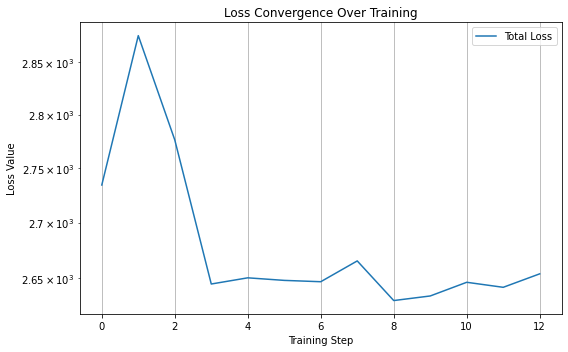

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Total Loss')
plt.xlabel("Training Step")
plt.ylabel("Loss Value")
plt.title("Loss Convergence Over Training")
plt.yscale('log')  # Optional: log scale helps if loss spans several orders of magnitude
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

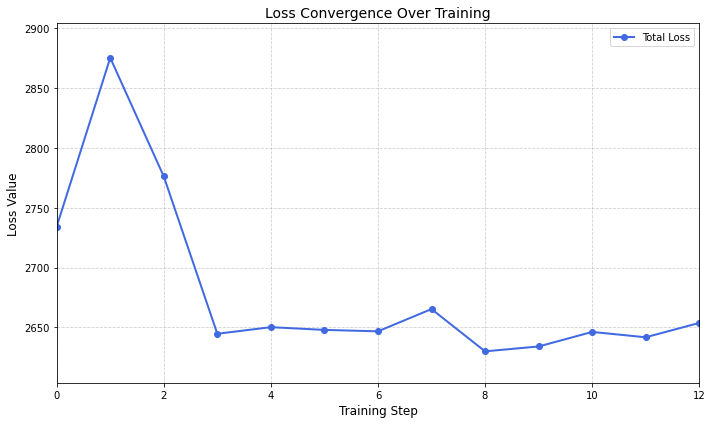

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Example: replace this with your actual loss values
# loss_history = [...]  # Your loss values from training loop

plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Total Loss', linewidth=2, color='royalblue', marker='o')

# Customize axes
plt.xlabel("Training Step", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.title("Loss Convergence Over Training", fontsize=14)

# Optional: manually adjust y-axis to focus on plateau region
plt.xlim(0, len(loss_history)-1)
plt.ylim(min(loss_history)*0.99, max(loss_history)*1.01)  # small buffer around range

# Optional: log scale to better show convergence if initial loss is very high
# plt.yscale('log')

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

2. Predicted fields (phi, n, zeta) post-training

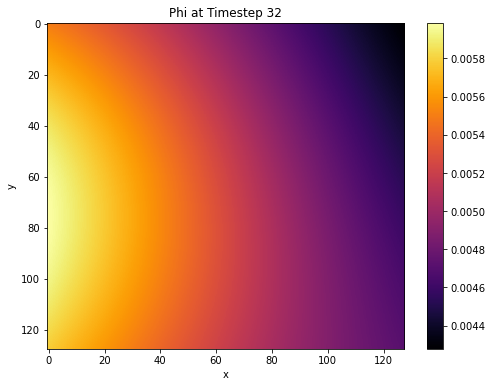

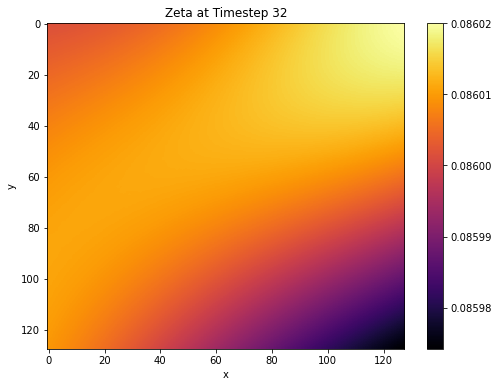

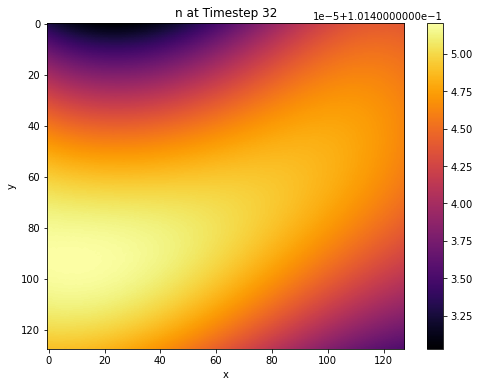

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def show_predicted_state(model, t_index, title, batch_size=30, device='cpu'):
    """
    Visualizes the predicted 2D field at a given timestep using batch processing in PyTorch.

    Parameters:
    - model: Trained PyTorch PINN model.
    - t_index: Timestep index for visualization.
    - title: Which field to plot ('Phi', 'Zeta', or 'n').
    - batch_size: Number of points to process per batch (default is 30 to match training).
    - device: Device on which the model is running ('cpu' or 'cuda').
    """
    model.eval()  # Set model to evaluation mode

    # Generate a spatial grid
    x_vals = np.linspace(-1, 1, 128)
    y_vals = np.linspace(-1, 1, 128)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Create input tensor with fixed time
    t_fixed = np.full_like(X, fill_value=t_index / 33.0)  # Normalize time (match your training setup)
    inputs = np.stack([X, Y, t_fixed], axis=-1)  # Shape: (128, 128, 3)

    # Reshape to (Nx * Ny, 3)
    inputs_tensor = torch.tensor(inputs.reshape(-1, 3), dtype=torch.float32).to(device)

    num_points = inputs_tensor.shape[0]
    predictions_phi, predictions_zeta, predictions_n = [], [], []

    with torch.no_grad():
        for i in range(0, num_points, batch_size):
            batch_input = inputs_tensor[i:i + batch_size]
            batch_input = batch_input.unsqueeze(0)  # Add batch dim: (1, batch_size, 3)

            phi_batch, zeta_batch, n_batch = model(batch_input)  # Forward pass

            predictions_phi.append(phi_batch.squeeze(0).cpu())
            predictions_zeta.append(zeta_batch.squeeze(0).cpu())
            predictions_n.append(n_batch.squeeze(0).cpu())

    # Concatenate and reshape predictions
    phi_grid = torch.cat(predictions_phi, dim=0).numpy().reshape(128, 128)
    zeta_grid = torch.cat(predictions_zeta, dim=0).numpy().reshape(128, 128)
    n_grid = torch.cat(predictions_n, dim=0).numpy().reshape(128, 128)

    field_map = {"Phi": phi_grid, "Zeta": zeta_grid, "n": n_grid}
    field = field_map.get(title, phi_grid)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.imshow(field, origin="upper", cmap="inferno", aspect="auto")
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{title} at Timestep {t_index}")
    plt.show()

# Example usage (assuming your model is loaded and on the right device):
t_index = 32
show_predicted_state(model, t_index, "Phi", batch_size=30)  # or 'cpu'
show_predicted_state(model, t_index, "Zeta", batch_size=30)
show_predicted_state(model, t_index, "n", batch_size=30)


## Evaluation
1. Submit notebook to NERSC
2. Hyperparameter optimization through Optuna
3. Normalization with other simulations (i.e., Gykell)